In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import networkx as nx


#from functions import load_parameters, timeIntegrationRK4
#---------------------------------------------------------
                
import numba 


In [0]:
def plotSpikeTrain(us, params):
    '''
    Spike train as an image. 
    Parameter dictionary is only passed for the image title.
    '''
    fig, ax = plt.subplots(1,1,figsize=(10,5), dpi=100)
    im = ax.pcolormesh(us, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    fig.colorbar(im, cax = cax)
    ax.set_xlabel('Simulated timesteps [dt={}ms]'.format(params['dt']))
    ax.set_ylabel(r'Activity $u(t)$ for each node')
    ax.set_title(r'Spike trains for $I={}, K={}, \sigma={}, c={}$'.format(params['I'],params['K'],params['sigma'],params['c']))
    plt.show()
    
def plotSpikeTrainappended(us, params):
    '''
    Spike train as an image. 
    Parameter dictionary is only passed for the image title.
    '''

    for i in range(len(us)):
      fig, ax = plt.subplots(1,1,figsize=(5,3), dpi=100)

      im = ax.pcolormesh(us[i], cmap='gray')
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="2%", pad=0.05)
      fig.colorbar(im, cax = cax)
      ax.set_xlabel('Simulated timesteps [dt={}ms]'.format(params[i]['dt']))
      ax.set_ylabel(r'Activity $u(t)$ for each node')
      ax.set_title(r'Spike trains for $I={}, K={}, \sigma={}, c={}$'.format(params[i]['I'],params[i]['K'],params[i]['sigma'],params[i]['c']))
      plt.show()

In [0]:
'''import numpy as np
import matplotlib.pyplot as plt
import numba
'''
def load_parameters(n,singleNode=False, globalN=0):
    class struct(object):
        pass

    params = struct()
    #FHN parameters with:
    '''
    du/dt = -alpha u^3 + beta u^2 - gamma u - w + I_{ext}
    dw/dt = 1/tau (u + delta  - epsilon w)
    '''
    params.alpha = 3. # eps in "kostova2005" paper
    params.beta = 4. # eps(1+lam)
    params.gamma = -1.5 # lam eps
    params.delta = 0.
    params.epsilon = 0.5 # a
    params.tau = 20. 
    
    ### runtime parameters
    params.dt = 0.1  # simulation timestep in ms 
    params.duration = 3000  # Simulation duration in ms

    ### network parameters
    if singleNode: # if you only want a single node with those parameters
        N = 1
        params.SC = np.zeros((N, N))
        params.DM = np.zeros((N, N))
    elif globalN>0: # if you want a network of N nodes, all uniformly connected
        N = globalN
        SC = np.ones((N,N))
        np.fill_diagonal(SC, 0)
        params.SC = SC

    else: # this is what you usually want! Here you load the netowrk topology from the DTI images
        SCs90_HCP10 = np.load('HCP10_SCs_aal90_EVnorm.npy')

        SC = SCs90_HCP10[n]#np.mean(SCs90_HCP10,axis=0)
       	
        N = SC.shape[0]          
        params.SC = SC
        
    params.N = N  # number of nodes

    ### global parameters
    params.I = 0.5 # Background input
    params.K = 0.  # global coupling strength
    params.sigma = 0. # Variance of the additive noise
    params.c = 0.  # signal transmission speed
    
    ### Initialization noise
    params.init = (0,0,0,0) #initialize randomly with u in [0,1] & w in [2,3]

    params_dict = params.__dict__
    return params_dict#SC.shape #SCs90_HCP10[0].size

# @numba.jit(nonpyhton=True)
def load_parameters_v(patient=0, singleNode=False, globalN=0):
    class struct(object):
        pass

    params = struct()
    #FHN parameters with:
    '''
    du/dt = -alpha u^3 + beta u^2 - gamma u - w + I_{ext}
    dw/dt = 1/tau (u + delta  - epsilon w)
    '''
    params.alpha = 3. # eps in "kostova2005" paper
    params.beta = 4. # eps(1+lam)
    params.gamma = -1.5 # lam eps
    params.delta = 0.
    params.epsilon = 0.5 # a
    params.tau = 20. 
    
    ### runtime parameters
    params.dt = 0.1  # simulation timestep in ms 
    params.duration = 3000  # Simulation duration in ms

    ### network parameters
    if singleNode: # if you only want a single node with those parameters
        N = 1
        params.SC = np.zeros((N, N))
        params.DM = np.zeros((N, N))
    elif globalN>0: # if you want a network of N nodes, all uniformly connected
        N = globalN
        SC = np.ones((N,N))
        np.fill_diagonal(SC, 0)
        params.SC = SC

    else: # this is what you usually want! Here you load the netowrk topology from the DTI images
        SCs90_HCP10 = np.load('HCP10_SCs_aal90_EVnorm.npy')
        if(patient>0 and patient<11):
          
          SC = SCs90_HCP10[patient-1]
        else: 
          SC =np.mean(SCs90_HCP10,axis=0)
       	
        N = SC.shape[0]          
        params.SC = SC
        
    params.N = N  # number of nodes

    ### global parameters
    params.I = 0.5 # Background input
    params.K = 0.  # global coupling strength
    params.sigma = 0. # Variance of the additive noise
    params.c = 0.  # signal transmission speed
    
    ### Initialization noise
    params.init = (0,0,0,0) #initialize randomly with u in [0,1] & w in [2,3]

    params_dict = params.__dict__
    return params_dict#SC.shape #SCs90_HCP10[0].size

def timeIntegrationRK4( params, randomseed=0, step=False, m= 90,fe=False,x=0,y=0):
    '''
    Integrate the FHN equations including noise and coupling with RK4 scheme using @numba 
    and return the trajectories for the potential and the recovery variable.
    Equations:
    du_i/dt = - alpha u_i^3 + beta u_i^2 + gamma u_i - w + I + K * SC_ij*u_j(t-c*DM_ij) + sigma*noise 
    dw_i/dt = u_i - delta - epsilon w_i / tau
    (in the implementation u=x, w=y, noise and delay are ignored)
    Args:
        params: Parameter dictionary obtained by load_parameters() + modifications
        Important parameters for the integration are:
            init: (u0min, u0max, w0min, w0max): Limits for randomly drawn initial conditions for every node [mV]
            alpha, beta, gamma: FHN node parameters, determine du/dt
            delta, epsilons=None, tau: FHN node parameters, determine dw/dt            
            I: Constant background input 
            K: >0, Global coupling strength
            sigma: >0, Variance of the additive noise
            c: >=0, Transmission speed, converts the connection length in DM (DTI data) to a delay, no delay for c=0
            dt: Timestep for simulation [ms]
            duration: Total simulated time [ms]
            randomseed: for reproducibility
    ''' 
    # load parameters from dictionary
    N = params['N']
    SC = params['SC']
    dt = params['dt']
    duration = params['duration']
    I = params['I']
    c = params['c']
    K = params['K']
    sigma = params['sigma']
    init = params['init']
   
    # FHN parameters
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    delta = params['delta']
    epsilon = params['epsilon']
    tau = params['tau']

    # return arrays
    ts = np.arange(0, duration, dt)
    xs = np.zeros((N, len(ts)))
    ys = np.zeros((N, len(ts)))
    
    if randomseed > 0:
        np.random.seed(randomseed)
    # initial conditions
    x_init = np.random.uniform(init[0], init[1], N)
    y_init = np.random.uniform(init[2], init[3], N)
    if (type(x)==int and type(y)==int):
      xs[:,0] = x_init
      ys[:,0] = y_init
    else:
      xs[:,0] = x
      ys[:,0] = y
      

    # actual integration is done with numba for speedup
    ts, xs, ys = timeIntegrationRK4Numba(dt, duration, 
                                N, SC, I, K, 
                                alpha, beta, gamma, delta, epsilon, tau,
                                ts, xs, ys, step, m,fe)
    
    return ts, xs, ys, x_init, y_init



In [0]:
  
@numba.njit(locals = {'idxX': numba.int64, 'idxY':numba.int64, 'idx1':numba.int64, 'idy1':numba.int64})

def timeIntegrationRK4Numba(dt, duration, 
                            N, SC, I, K, 
                            alpha, beta, gamma, delta, epsilon, tau,
                            ts, xs, ys, step, m,fe):
    # load initial values
    x = xs[:,0].copy()
    y = ys[:,0].copy()
    I_def = I
    if(step==True):
      I = 0
    for t in range(len(ts)):
      if step ==True:
        if (t %3000 ==0):
          I+=0.1
          I_def = I
      for n in range(N):# loop over all nodes
            if(m <90 ):
              if (n== m):
                if(fe==True):
                  if(t>int(len(ts)/2)):
                    I=0.6
                  else:
                    I=I_def
                else:
                  I=0.6
              elif(step==True): 
                I = I_def
              else:#
                I = I_def
            x_ext = 0  # input from other nodes to the activation variable

              
            for i in range(N):# get input of every other node

                x_ext = x_ext + SC[i, n] * xs[i, t]
            # update FHN equations - use RK4 integration scheme (don't mind too much what happens here...)
            x_k1 = - alpha * x[n]**3 + beta * x[n]**2 + gamma * x[n] - y[n] + K * x_ext + I
            y_k1 = (x[n] - delta - epsilon*y[n])/tau
            x_k2 = - alpha * (x[n]+0.5*dt*x_k1)**3 + beta * (x[n]+0.5*dt*x_k1)**2 + gamma * (x[n]+0.5*dt*x_k1) - (y[n]+0.5*dt*y_k1) + K * x_ext + I
            y_k2 = ((x[n]+0.5*dt*x_k1) - delta - epsilon*(y[n]+0.5*dt*y_k1))/tau
            x_k3 = - alpha * (x[n]+0.5*dt*x_k2)**3 + beta * (x[n]+0.5*dt*x_k2)**2 + gamma * (x[n]+0.5*dt*x_k2) - (y[n]+0.5*dt*y_k2) + K * x_ext + I
            y_k3 = ((x[n]+0.5*dt*x_k2) - delta - epsilon*(y[n]+0.5*dt*y_k2))/tau
            x_k4 = - alpha * (x[n]+1.0*dt*x_k3)**3 + beta * (x[n]+1.0*dt*x_k3)**2 + gamma * (x[n]+1.0*dt*x_k3) - (y[n]+1.0*dt*y_k3) + K * x_ext + I
            y_k4 = ((x[n]+1.0*dt*x_k3) - delta - epsilon*(y[n]+1.0*dt*y_k3))/tau
            
            ### update x_n
            x[n] = x[n] + 1./6.*(x_k1+2*x_k2+2*x_k3+x_k4) * dt
            y[n] = y[n] + 1./6.*(y_k1+2*y_k2+2*y_k3+y_k4) * dt

            ### save state
            xs[n,t+1] = x[n]
            ys[n,t+1] = y[n]

    return ts, xs, ys

  

  



## Zeroth Case: Single Node


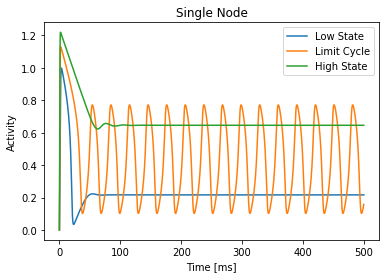

In [9]:
par0LS = load_parameters(n=0,singleNode=True)
par0LS['duration']=500; par0LS['I'] = 0.6
ts, xs0LS, _, _,_ = timeIntegrationRK4(par0LS, randomseed=42)
plt.plot(ts, xs0LS[0], label='Low State')
par0LC = load_parameters(0,singleNode=True)
par0LC['duration']=500; par0LC['I'] = 1.
ts, xs0LC, _, _,_ = timeIntegrationRK4(par0LC, randomseed=42)
plt.plot(ts, xs0LC[0], label='Limit Cycle')
par0HS = load_parameters(0,singleNode=True)
par0HS['duration']=500; par0HS['I'] = 1.4
ts, xs0HS, _, _,_ = timeIntegrationRK4(par0HS, randomseed=42)
plt.plot(ts, xs0HS[0], label='High State')
plt.xlabel('Time [ms]');plt.ylabel('Activity');plt.title('Single Node')
plt.legend();plt.show()

# "Network Dynamics Playground"
## First Case: No Activity
$K \equiv 0$ (no coupling between the nodes) and  $I_{ext} \equiv 0.6$ (before bifurcation)

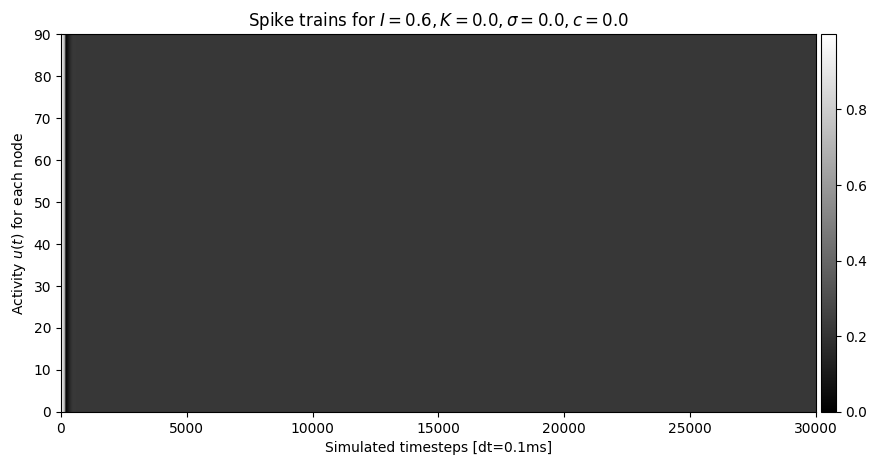

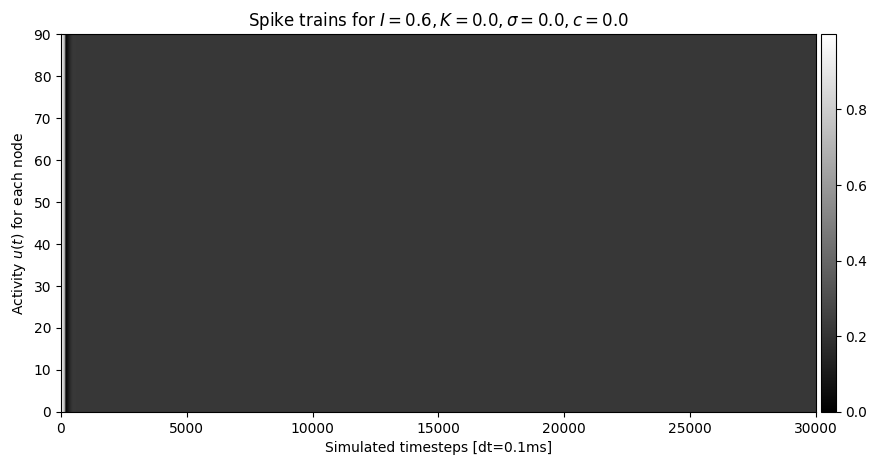

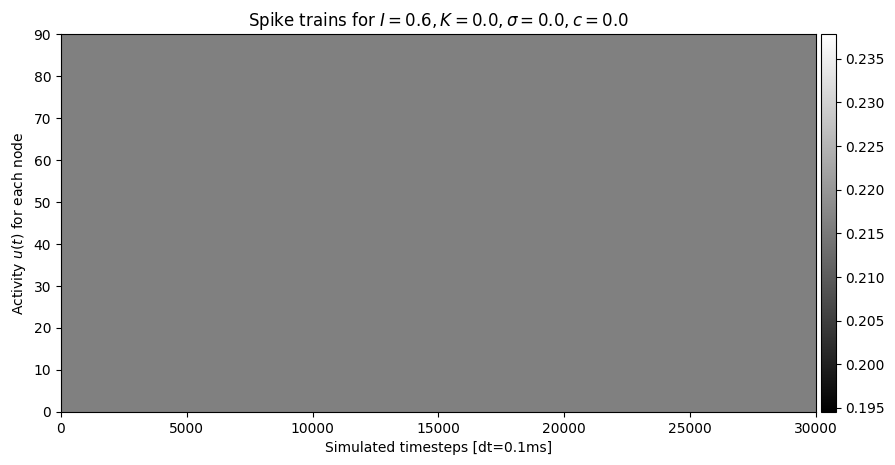

In [39]:
par1 = load_parameters_v()
par1['I'] = 0.6
par1['K'] = 0.0

m=0
#ts, xs1, ys, _,_ = timeIntegrationRK4(par1, randomseed=42)
ts, xs1, ys, _,_ = timeIntegrationRK4(par1, randomseed=42, step=False, m =22)
ts, xs12,ys12, _,_ = timeIntegrationRK4(par1, randomseed=42, step=False)
plotSpikeTrain(xs1, par1)
plotSpikeTrain(xs12,par1)
ts, xs123,ys, _,_ = timeIntegrationRK4(par1, randomseed=42, step=False,x=xs12[:,29999],y=ys12[:,29999])
plotSpikeTrain(xs123,par1)
np.linalg.norm(xs12-xs123)
dist0 = xs1



## Second Case: Individual Nodes
$K \equiv 0$ (no coupling between the nodes) and  $I_{ext} \equiv 0.8$ (in limit cycle)

In [0]:
# par2 = load_parameters_v()
# par2['I'] = 0.8
# par2['K'] = 0.0

# ts, xs2, ys, _,_ = timeIntegrationRK4(par2, randomseed=42, step=False)

# plotSpikeTrain(xs2, par2)

## Third (and interesting) Case: Coupling Leads to Activity
$K \equiv 0.5$ (nodes are coupled according to structual connectivity matrix) and  $I_{ext} \equiv 0.6$ (constant background)

# ...

In [0]:
# par3 = load_parameters_v()
# par3['I'] = 0.362
# par3['K'] = 0.6
 
# ts, xs3, ys, _,_ = timeIntegrationRK4(par3, randomseed=42, step=False, m=22,x=xs12[:,29999],y=ys12[:,29999])

# plotSpikeTrain(xs3[:,5000:10000], par3)

In [0]:
# par3 = []#load_parameters(0)
# xs3_ = []
# for i in range(10):
#   par3.append(load_parameters(i))
  
#   par3[i]['I'] = 0.6
#   par3[i]['K'] = 0.5

#   ts, xs3, ys, _,_ = timeIntegrationRK4(par3[i], randomseed=43,step=True)
#   xs3_.append(xs3)
#   #plotSpikeTrain(xs3, par3[i])
# plotSpikeTrainappended(xs3_,par3)

In [0]:
# par4 = load_parameters_v()
# par4['I'] = 0.6
# par4['K'] = 0.2

# ts, xs4, ys, _,_ = timeIntegrationRK4(par4, randomseed=43,step=True,m=21,x=xs12[:,29999],y=ys12[:,29999])

# plotSpikeTrain(xs4, par4)

In [0]:

# par3 = []#load_parameters(0)
# xs3_ = []
# for i in range(10):
#   par3.append(load_parameters(i))
  
#   par3[i]['I'] = 1
#   par3[i]['K'] = 0.5

#   ts, xs3, ys, _,_ = timeIntegrationRK4(par3[i], randomseed=43)
#   xs3_.append(xs3)
#   #plotSpikeTrain(xs3, par3[i])
# plotSpikeTrainappended(xs3_,par3)

In [0]:
par4 = load_parameters_v(patient=1)
par4['I'] = 0.36
par4['K'] = 0.71

ts, xs4, ys, _,_ = timeIntegrationRK4(par4, randomseed=43,m=22,x=xs12[:,29999],fe=True,y=ys12[:,29999])

plotSpikeTrain(xs4, par4)

# Variance beteween subjects during the simulation 

In [0]:
# par3 = []#load_parameters(0)
# xs3_ = []
# for i in range(10):
#   par3.append(load_parameters(i))
  
#   par3[i]['I'] = 0.6
#   par3[i]['K'] = 0.2

#   ts, xs3, ys,_,_ = timeIntegrationRK4(par3[i], randomseed=43)
  
#   xs3_.append(xs3)
#   #plotSpikeTrain(xs3, par3[i])
  
# a= np.array(xs3_)

# # plotSpikeTrain(np.var(a,axis=0),par3[0])

Creates a dictionary for all the nodes with stimulus in order of activation (0->89) (u=0.6)




#Value dictionary

In [0]:
# k=0
# patient_list_fe0 = []
# patient_list_fe1 = []
# for k in range(10):
dist1_fe0 ={}
dist1_fe1={}
#   print(k)
#   a = np.arange(0,1,0.05)
for i in range(90):#a:
    par5 = load_parameters_v()
    par5['I'] = 0.36
    par5['K'] = 0.6
    ts, xs5, ys, _,_ = timeIntegrationRK4(par5, randomseed=43,step=False, m=i,x=xs12[:,29999],y=ys12[:,29999]) #initialization with low input
    dist1_fe0[i] = xs5
    ts, xs6, ys, _,_ = timeIntegrationRK4(par5, randomseed=43,step=False, m=i,fe=True,x=xs12[:,29999],y=ys12[:,29999]) #initialization with low input
    dist1_fe1[i] = xs6
#   patient_list_fe0.append(dist1_fe0)
#   patient_list_fe1.append(dist1_fe1)

#       if(i ==22):
#         plotSpikeTrain(xs5, par5)
#         plotSpikeTrain(xs6, par5)

def create_val_dict(K,I ,node=100,patient=0):
#     k=0
    dist1_fe0 ={}
    dist1_fe1={}

    
    for i in range(90):#a:
        par5 = load_parameters_v(patient=patient)
        par5['I'] = I
        par5['K'] = K
        ts, xs5, ys, _,_ = timeIntegrationRK4(par5, randomseed=43,step=False, m=i,x=xs12[:,29999],y=ys12[:,29999]) #initialization with low input
        dist1_fe0[i] = xs5
        ts, xs6, ys, _,_ = timeIntegrationRK4(par5, randomseed=43,step=False, m=i,fe=True,x=xs12[:,29999],y=ys12[:,29999]) #initialization with low input
        dist1_fe1[i] = xs6


    #     if(k==89):
    #       break
    #     else:
    #       k+=1
        if(i ==node):
          plotSpikeTrain(xs5, par5)
          plotSpikeTrain(xs6, par5)
    return(dist1_fe0,dist1_fe1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

In [0]:

# @numba.jit(nopython=True, parallel=True)
def create_val_arr(K,I ,node=100,patient=0):
#     k=0
    dist1_fe0 = []
    dist1_fe1= []
    a = np.arange(90)
    
    for i in a:#a:
        par5 = load_parameters_v(patient=patient)
        par5['I'] = I
        par5['K'] = K
        ts, xs5, ys, _,_ = timeIntegrationRK4(par5, randomseed=43,step=False, m=i,x=xs12[:,29999],y=ys12[:,29999]) #initialization with low input
        dist1_fe0.append(xs5)
        ts, xs6, ys, _,_ = timeIntegrationRK4(par5, randomseed=43,step=False, m=i,fe=True,x=xs12[:,29999],y=ys12[:,29999]) #initialization with low input
        dist1_fe1.append(xs6)


    #     if(k==89):
    #       break
    #     else:
    #       k+=1
        if(i ==node):
          plotSpikeTrain(xs5, par5)
          plotSpikeTrain(xs6, par5)
    return(dist1_fe0,dist1_fe1)

In [0]:
# K = [0.7,0.55,0.51,0.56,0.53,0.56,0.61,0.49,0.56,0.53]
# # for i in range(len(K)):
# #   print(i)
# ener,func = create_val_dict(K=K[0],I=0.36,patient=1)
# patient1= (ener,func)
# with open('drive/variables.pickle', 'w') as f:
#   pickle.dump(patient1, f)

In [0]:
# with open('drive/variables.pickle', 'r') as f:
#   patient1 = pickle.load(f)

# patient1

In [0]:
# ener,func=create_val_dict(K=0.55,I=0.36,patient=2)
# %store ener >>a.txt

# len(patient_list_fe0)
# dict0,dict1=create_val_dict(K=0.6,I=0.36,patient=1)
# plotSpikeTrain(dict0, par5)
# dict0

In [0]:
# max_val = np.argmax(xs5[22])
# min_val = np.argmin(xs5[22])
# m=[]
# count =0
# for i in xs5[22]:
  
#   if (i <max_val):
#     m.append((count,i))
#   count+=1
# max_val,min_val

**As suggested, energy of the signal is calcuated by summing the squared values over time. Then the absolute value of the difference between the L2 distance over the energy vector before and after simulation is calculated.**




In [0]:
ener,vals = create_val_arr(0.6,0.36,patient=0)


In [0]:
ener

array([], dtype=float64)

In [0]:
# from numba import njit
e_dict = []
f_dict = []
# @njit
@numba.jit(nopython=True, parallel=True)

def arr_for_patient():
  val = np.array([])
  for i in range(10):
    print(i)
    e_dict,fe_dict = create_val_arr(0.6,0.36,patient=i+1)
    np.append(val,np.array([e_dict,fe_dict]))
    return(val)


In [24]:
arr_for_patient()

TypingError: ignored

# Energy calculation

In [43]:
#Energy calculation
# summ=[]
# energy_input = []
# time = 1/(ts[-1]-ts[4999])
# dict_val={}
# # print((dist1_fe0.keys()))
# for i in dist1_fe0.keys():
#   #sum of the energy for the signal is taken () __Negative correlation in this case
#   ##summ.append(np.absolute(np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1))- np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)))) 
  
#   #summ.append((np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1)*time,ord=1) - np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)*time,ord=1))) #sum of the energy for the signal is taken ()
#   summ.append(np.absolute(np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1)*time,ord=1)))#- np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)*time,ord=1))) #sum of the energy for the signal is taken ()
#   energy_input.append(np.absolute(np.sum(dist1_fe0[i][i,5000:]**2)*time ))
#   #summ.append(np.sum(dist1_fe0[i][:,5000:]**2)*time)

  

def energy(dictionary):
  summ=[]
  energy_input = []
  time = 1/(ts[-1]-ts[4999])
  dict_val={}
  # print((dist1_fe0.keys()))
  for i in dictionary.keys():
    #sum of the energy for the signal is taken () __Negative correlation in this case
    ##summ.append(np.absolute(np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1))- np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)))) 

    #summ.append((np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1)*time,ord=1) - np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)*time,ord=1))) #sum of the energy for the signal is taken ()
    summ.append(np.absolute(np.linalg.norm(np.sum(dictionary[i][:,5000:]**2,axis=1)*time,ord=1)))#- np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)*time,ord=1))) #sum of the energy for the signal is taken ()
    energy_input.append(np.absolute(np.sum(dictionary[i][i,5000:]**2)*time ))
  return(summ)
energy_value = energy(ener)
    #summ.append(np.sum(dist1_fe0[i][:,5000:]**2)*time)

TypeError: ignored

In [0]:

def energy(dictionary):
  summ=[]
  energy_input = []
  time = 1/(ts[-1]-ts[4999])
  dict_val={}
  # print((dist1_fe0.keys()))
  for i in dictionary.shape():
    #sum of the energy for the signal is taken () __Negative correlation in this case
    ##summ.append(np.absolute(np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1))- np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)))) 

    #summ.append((np.linalg.norm(np.sum(dist1_fe0[i][:,5000:]**2,axis=1)*time,ord=1) - np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)*time,ord=1))) #sum of the energy for the signal is taken ()
    summ.append(np.absolute(np.linalg.norm(np.sum(dictionary[i][:,5000:]**2,axis=1)*time,ord=1)))#- np.linalg.norm(np.sum(dist0[:,5000:]**2,axis=1)*time,ord=1))) #sum of the energy for the signal is taken ()
    energy_input.append(np.absolute(np.sum(dictionary[i][i,5000:]**2)*time ))
  return(summ)


# Functional Effect 
For each  node = mean(absolute(corrMatrix_before_stimulation - corrMatrix_after_stimulation ))

In [0]:
def functional_eff(xs):
  diff = 0
  d_val = []
  for i in xs.keys():
    diff = np.linalg.norm(np.absolute(np.corrcoef(xs[i][:,5000:14999]) - np.corrcoef(xs[i][:,16000:])))
    d_val.append(diff)
    
  return np.array(d_val) 
f_eff=functional_eff(dist1_fe1)


In [0]:
SCs90 = np.load('HCP10_SCs_aal90_EVnorm.npy')
a_ = np.mean(SCs90,axis=0)
a = np.mean(np.mean(SCs90,axis=0),axis=0)
l2Dist= pd.Series(data=energy_value)
F_eff = pd.Series(data=f_eff)
degree = pd.Series(data=a)
d = {'Degree':degree,'Energy(Over T)':l2Dist}
dwf = {'Degree':a,'Functional Effect':F_eff}
dwf0 = {'Energy(Over T)':l2Dist,'Functional Effect':F_eff}
df1 = pd.DataFrame(data=d)
df2 = pd.DataFrame(data=dwf)
df3 = pd.DataFrame(data=dwf0)
#+print(df)


df1.plot(kind='scatter',x='Degree',y='Energy(Over T)')
df2.plot(kind='scatter',x='Degree',y='Functional Effect')
df3.plot(kind='scatter',x='Energy(Over T)',y='Functional Effect')
plt.show()


In [0]:
#print(df1.values)
from scipy import stats
print("Pearson-Correlattion r & P values for Degree V.Energy(Over T) ",stats.pearsonr(x=df1['Degree'],y=df1['Energy(Over T)']))
print("Pearson-Correlattion r & P values for Degree V. Functional Effect" ,stats.pearsonr(x=df2['Degree'],y=df2['Functional Effect']))
print("Pearson-Correlattion r & P values for Energy(Over T) V. Functional Effect ",stats.pearsonr(x=df3['Energy(Over T)'],y=df3['Functional Effect']))

In [0]:
"""
Step input to the integration 

Trying closer to bifurcation point 

Correlation v. Current study (study the sensitivity)

Effect of different nodes 

Find the peak of the oscillation 

Finding the parameter configuration for firing. 
I =[0.73, 0.65, 0.6,0.52,0.47,0.41,0.36,0.32,0.27,0.24]
K =[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Identify the nodes 

Distance between the matrices

Identify the steps before and after the bifurcation 
Degree is defined as the average weight of edges emanating from that region. 


We assess the pairwise change in functional brain states by subtracting the correlation values obtained in the stimulation-free time window before the stimulation is applied from the correlation values obtained in the time window during the stimulation. 
We then measure the average change in functional brain states, termed the functional effect, as the absolute value of this difference averaged over all region pairs. 
The greater the deviation of the functional effect from zero, the greater the effect of stimulation on brain state reconfiguration.
"""



"""L2 Distance - Average
Take Energy (squared values)for each node 
Look into large limit cycle
"""

'''
Ideas - Input signal mean energy over time 
Show how the network dynamics change when a control is added for high degree, medium and low degree 



Use the adjacency matrix for the weights in the 
shortest path and loop over all the starting and the target nodes


Use pseudo inverse (Done) 

Functional effect and energy correlation with the measurement correlations matrix (Done)


Variance of the measures/correlations between subjects in the correlation matrix 

Box plot for variability 





Eigen values changes with the exclusion of of nodes 




p 1    2    3    4    5    6    7    8    9    10
K 0.7  0.55 0.51 0.56 0.53 0.56 0.61 0.49 0.56 0.53
'''

In [0]:
np.argmax(np.mean(SCs90[1],axis=1))
np.argsort(np.mean(SCs90[1],axis=1),kind='quicksort')

In [0]:

#Node Energy
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot( np.arange(0,90),energy_value)
plt.xlabel('Node')
plt.ylabel('Energy')
plt.show()

In [0]:
plotSpikeTrain(vals[22],par5) #High
plotSpikeTrain(vals[0],par5)   #Medium
plotSpikeTrain(vals[78],par5)  #Low

# Network Parameters

In [0]:
import seaborn as sns; sns.set()
uniform_data = np.random.rand(10, 12)
#ax = sns.heatmap(degree)

l = np.copy(a_)
ax = sns.heatmap(a_)
plt.show()

temp1 = []
temp2 = []
temp3 = []
temp4 = []

for i in range(90):
  if(i%2==0):
    temp1.append(l[i])
  else:
    temp2.append(l[i])

glf = np.concatenate((np.array(temp1),np.array(temp2)))
a = glf.T
for i in range(90):

  if(i%2==0):
    temp3.append(a[i])
  else:
    temp4.append(a[i])
    
final = np.concatenate((np.array(temp3),np.array(temp4)))
final.shape
ax = sns.heatmap(final)

plt.show()

In [0]:
l = np.copy(SCs90[0])
ax = sns.heatmap(SCs90[0])
plt.show()

temp1 = []
temp2 = []
temp3 = []
temp4 = []

for i in range(90):
  if(i%2==0):
    temp1.append(l[i])
  else:
    temp2.append(l[i])

glf = np.concatenate((np.array(temp1),np.array(temp2)))
a = glf.T
for i in range(90):

  if(i%2==0):
    temp3.append(a[i])
  else:
    temp4.append(a[i])
    
final = np.concatenate((np.array(temp3),np.array(temp4)))
final.shape
ax = sns.heatmap(final)

plt.show()

In [0]:
sns.heatmap(a_)



#Modal Controllability

In [0]:
import scipy as sc
def modal_control(v):
  A = v/(1+sc.sparse.linalg.svds(v,1)[1])
  U,T = sc.linalg.schur(A,output='real')
  eigVals = np.diag(U)
  v = np.diag(eigVals)


  #  sns.heatmap(A)
  # sns.heatmap(a_)

  phi = []

  for i in range(A.shape[1]):
    phi.append(np.sum(np.square(v)-np.matmul(np.square(T[i][:]),np.square(v))))
  return(phi)
# phi = np.mean(phi,axis=0)


fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot( np.arange(0,90),modal_control(a_))
plt.xlabel('Nodes')
plt.ylabel('Modal controllability')
plt.show()



# return phi_p
# mode = modal_control(a_)
# mode_subj=modal_control(SCs90[1])




# phi[i] += (np.square(U[i][:]))*(1-np.square(eigVals))
# sc.sparse.linalg.svds(a_,1)
# eig_v = np.linalg.eigvals(a_)
# A = a_/(1+np.max(eig_v))
# v = A
# eig= np.linalg.eig(v)[1]
# modes = sc.stats.mode(SCs90[1])
# modes

# # eig[1][1]
# temp = np.mean(modes,axis=1)
# phi = []
# phi_temp=0
# for i in range(modes.size):
#   for j in range(modes.size):
#     phi_temp += (1-modes[i][j]**2)*(eig[i][j]**2)
#   phi.append(phi_temp)
#   phi_temp=0
# phi_p=np.linalg.norm(phi)

In [0]:
sns.heatmap(a_)


#Average Controllability 

In [0]:
# from numba import jit


# @numba.jit(locals = {'idxX': numba.int64, 'idxY':numba.int64, 'idx1':numba.int64, 'idy1':numba.int64})

# def avg_controllability_pa(a_):
#   w_k = []
#   B_k = np.identity(90)
#   a = 0
#   avg_control = []
#   for m in range(90):
#     temp1 = np.zeros(8100).reshape(90,90)
    
#     for i in range(100):
#       temp1=temp1+np.matmul((np.mat(a_**i)),np.matmul(np.matrix((B_k[m])),np.matmul(np.matrix(B_k[m].T),np.mat((a_**i)))))
#     w_k.append(temp1)
  
#   for i in (w_k):
#     avg_control.append(np.trace(np.linalg.pinv(i)))
#   return(avg_control)

from numpy import matlib
def avg_controllability(a):

  A = a_#/(1+sc.sparse.linalg.svds(a_,1)[1])
  U,T = sc.linalg.schur(A,output='real')
  #   midMat = np.matrix((T**2)).getH()
  midMat = np.matrix((T**2)).T
  v1=np.diag(U)

  # v_mat = np.diag(v1)
  # np.matmul(np.matrix(v1).T,np.matrix(v1))
  # # np.diag(np.matrix(1- np.matmul(v1,v1.T)))
  P =np.matlib.repeat(np.diag(1-np.matmul(np.matrix(v1).T,np.matrix(v1))),90).reshape(90,90)


  # # midMat
  # # v1*np.matrix(v1).T
  # # np.matrix(v1)*np.matrix(v1).getH()
  # # l = np.linalg.norm(np.divide(midMat,P),axis=0)
  values = np.sum(np.divide(midMat,P),axis=0).T
  # values
  return(values, midMat)

# fig = plt.figure()
# ax = plt.axes()

# # x = np.linspace(0, 10, 1000)
# plt.plot( np.arange(0,90),values)
# plt.xlabel('Nodes')
# plt.ylabel('Average controllability')
# plt.show()
# A = A./(1+svds(A,1));     % Matrix normalization 
# [U, T] = schur(A,'real'); % Schur stability
# midMat = (U.^2)';
# v = diag(T);
# P = repmat(diag(1 - v*v'),1,size(A,1));
# values = sum(midMat./P)';

In [0]:
avg_control,_ = avg_controllability(a_)
avg_control = np.array(avg_control)



In [0]:
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot( np.arange(0,90),avg_control)
plt.xlabel('Nodes')
plt.ylabel('Average controllability')
plt.show()

In [0]:
# avg = avg_controllability_pa(a_)


# fig = plt.figure()
# ax = plt.axes()

# x = np.linspace(0, 10, 1000)
# ax.plot( np.arange(0,90),avg)
# plt.xlabel('Nodes')
# plt.ylabel('Average controllability')
# plt.show()

In [0]:
# shortest_path=[]
# D = nx.from_numpy_matrix(a_)
# degree = nx.degree(D) #
# short =nx.shortest_path_length(D)
# closeness=nx.centrality.closeness_centrality(D)
# triangels=nx.triangles(D)
# betweenness=nx.centrality.betweenness_centrality(D)
# degree_cent=nx.centrality.degree_centrality(D)
# clustering = nx.average_clustering(D)

# d_series=pd.Series(i[1] for i in degree)
# short_series = pd.Series(short)
# #   for i in short_series:
# #     print(i)
# clos_series= pd.Series(closeness)
# tri_ser =pd.Series(triangels)
# b_ser = pd.Series(betweenness)
# deg_ser=pd.Series(degree_cent)
# avg_ser=pd.Series(avg_control.reshape(90,))
# temp_dict = {'degree':d_series,'closeness_centrality':clos_series,'triangles':tri_ser,
#              'betweenness_centrality':b_ser,
#              'degree_centrality':deg_ser,'energy':l2Dist,
#              'functional effect':F_eff,'modal_controllability':mode,'average_controllability':avg_ser}
# df_hm = pd.DataFrame(data=temp_dict)
# arr = np.array(df_hm.values)
# matr = np.corrcoef(arr.T)
# fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
# ax1.boxplot(matr)


In [0]:
from networkx.algorithms import bipartite
from scipy import sparse
def correlation_plot_bw_measures(a,energy, func,mode,average):
  shortest_path=[]
  D = nx.from_numpy_matrix(a)
  degree = nx.degree(D) #
  short =nx.shortest_path_length(D)
  closeness=nx.centrality.closeness_centrality(D)
  triangels=nx.triangles(D)
  betweenness=nx.centrality.betweenness_centrality(D)
  degree_cent=nx.centrality.degree_centrality(D)
  clustering = nx.average_clustering(D)

  d_series=pd.Series(i[1] for i in degree)
  short_series = pd.Series(short)
#   for i in short_series:
#     print(i)
  clos_series= pd.Series(closeness)
  tri_ser =pd.Series(triangels)
  b_ser = pd.Series(betweenness)
  deg_ser=pd.Series(degree_cent)
  avg_ser=pd.Series(average.reshape(90,))
  temp_dict = {'degree':d_series,'closeness_centrality':clos_series,'triangles':tri_ser,
               'betweenness_centrality':b_ser,
               'degree_centrality':deg_ser,'energy':energy,
               'functional effect':func,'modal_controllability':mode,'average_controllability':avg_ser}
  df_hm = pd.DataFrame(data=temp_dict)
  arr = np.array(df_hm.values)
  index = df_hm.columns.values

  sA = sparse.csr_matrix(a_)
  bp = bipartite.from_biadjacency_matrix(sA)
  node_set_a,b = bipartite.sets(bp)
  # b
  # print(bipartite.density(bp,node_set_a))
  bipartite.closeness_centrality(bp,node_set_a)
  #bipartite.biadjacency_matrix(bp,node_set)
  bipartite.betweenness_centrality(bp,node_set_a)
  bipartite.closeness_centrality(bp,node_set_a)

  fig = plt.figure()

  matr = np.corrcoef(arr.T)
  ax = sns.heatmap(matr)
  fig.suptitle("Pearson correlations between measures")
  ax = sns.heatmap(matr.T,xticklabels=index,yticklabels=index)

  plt.show()
  
  return(matr, df_hm)


In [0]:
# correlation_plot_bw_measures(a_,l2Dist,F_eff,mode,avg_control)
K = [0.7,0.55,0.51,0.56,0.53,0.56,0.61,0.49,0.56,0.53]
correlations = []
measures = []
for i in range(10):
  
#   print(i)
#   temp = create_val_dict(K=K[i],I=0.36,patient=i+1)
  
  l2Dist_= pd.Series(data=energy(ener))
  F_eff_ = pd.Series(data=functional_eff(vals))
  
  mode1 = modal_control(SCs90[i])

  avg_control1 = avg_controllability(SCs90[i])
  
  a,b=correlation_plot_bw_measures(SCs90[i],l2Dist,F_eff,mode1,avg_control)
  measures.append(b)
  correlations.append(a)
  
  
  

In [0]:
temp_dict1 = {'degree':[],'closeness_centrality':[],'triangles':[],
               'betweenness_centrality':[],
               'degree_centrality':[],'energy':[],
               'functional effect':[],'modal_controllability':[],'average_controllability':[]}


temp = []
for i in measures:
  temp.append(i.mean(axis=0).values)
  
mat = np.matrix(temp)
columns=['degree','closeness_centrality','triangles',
               'betweenness_centrality',
               'degree_centrality','energy',
               'functional effect','modal_controllability','average_controllability']
df_hm1 = pd.DataFrame(data=mat,columns=columns)
for i in columns:
  plt.boxplot(df_hm1[i],labels=[i])
  plt.show()
# df = pd.DataFrame(np.random.randn(10,4),columns=['Col1', 'Col2', 'Col3', 'Col4'])
# boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3'])

In [0]:
temp2 = []
for i in correlations:
  temp2.append(i.mean(axis=0))
  
matr = np.matrix(temp2)
columns=['degree','closeness_centrality','triangles',
               'betweenness_centrality',
               'degree_centrality','energy',
               'functional effect','modal_controllability','average_controllability']
df_hm2 = pd.DataFrame(data=matr,columns=columns)

plt.boxplot(df_hm2.values,labels=columns,vert=False)
plt.show()

In [0]:
temp3 = []
for i in correlations:
  temp3.append(np.matrix(i))
  
var = np.var(temp3,axis=0)

fig.suptitle("Pearson correlations between measures")
ax = sns.heatmap(var,xticklabels=columns,yticklabels=columns)

plt.show()


In [31]:
a = np.histogram(SCs90)


plt.hist(x=a[0],bins= a[1], histtype='step')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

NameError: ignored